In [27]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

## Initialization

In [28]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]

downfreq = 128

plot = False

In [29]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
figure_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_figures'
evokeds_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_ERP_data'

subjects_to_process = ['01', '05']
period = 'post'

In [32]:
#======================================================================================
#                        CALCULATE EVOKEDS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    print('\nPROCESSING SUBJECT ', folder)
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_motor_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    

    #--------------------------------------------
    #               LOAD FILE AND EVENTS
    #--------------------------------------------
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events_sv = data['events']

    #making raw object from .mat data
    info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')
    raw = mne.io.RawArray(eeg, info = info_raw)
    raw.set_montage('biosemi64')

    #check psd
    if plot:
        mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)  

    #--------------------------------------------
    #               ICA
    #--------------------------------------------
    ica = ICA(max_iter="auto", random_state=97)
    ica.fit(raw)

    #exclude components
    ica.exclude = [0] #TO CORRECT LATER
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)


    #--------------------------------------------
    #               SET UP TRIGGERS
    #--------------------------------------------
    events_arr = make_raw_events(events_sv)
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

     
    #--------------------------------------------
    #               SET UP EVOKEDS OBJECTS
    #--------------------------------------------
    epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.2, tmax=0.5, preload=True)
    evoked = epochs.average()

    #plot evoked
    if plot:
        evoked.plot(titles = f'Motor-only keystrokes {period} sub{subject_ID}')
        evoked.plot_topomap(times=[0.1, 0.2, 0.5], average=0.0001)




    #--------------------------------------------
    #         SAVE DATA
    #--------------------------------------------
    mne.write_evokeds(f'{evokeds_folder}/motor_ERP_{period}_{subject_ID}.fif', evoked)

    


PROCESSING SUBJECT  01
Opening eeg_motor_post_01.mat
Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/1276092499.py:37: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 6.2s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
386 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 386 events and 91 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

PROCESSING SUBJECT  04

PROCESSING SUBJECT  05
Opening eeg_motor_post_05.mat
Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.
Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/1276092499.py:69: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_ERP_data/motor_ERP_post_01.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/motor_ERP_{period}_{subject_ID}.fif', evoked)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/1276092499.py:37: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 5.0s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Not setting metadata
215 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 215 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/1276092499.py:69: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_ERP_data/motor_ERP_post_05.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/motor_ERP_{period}_{subject_ID}.fif', evoked)


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


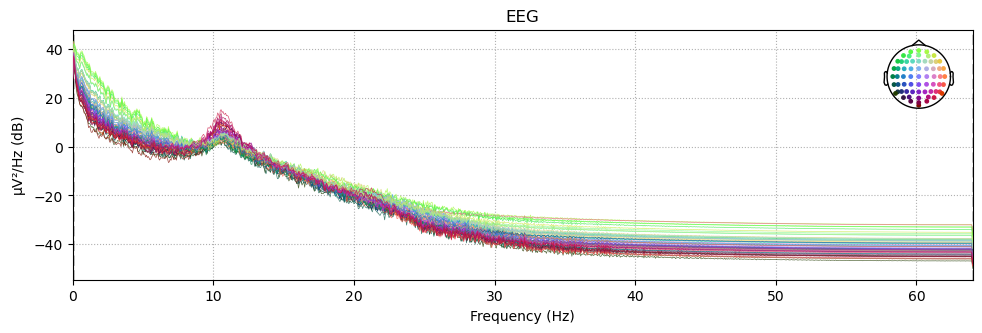

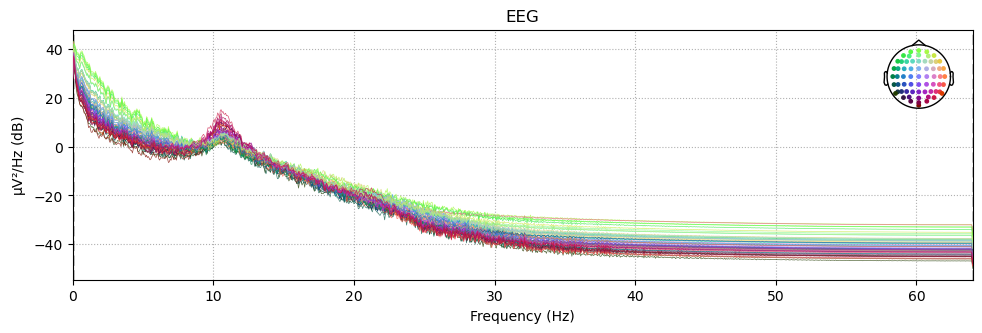

In [6]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

## ICA

In [7]:
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/3142827221.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 7.5s.


Method,fastica
Fit,93 iterations on raw data (74240 samples)
ICA components,64
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


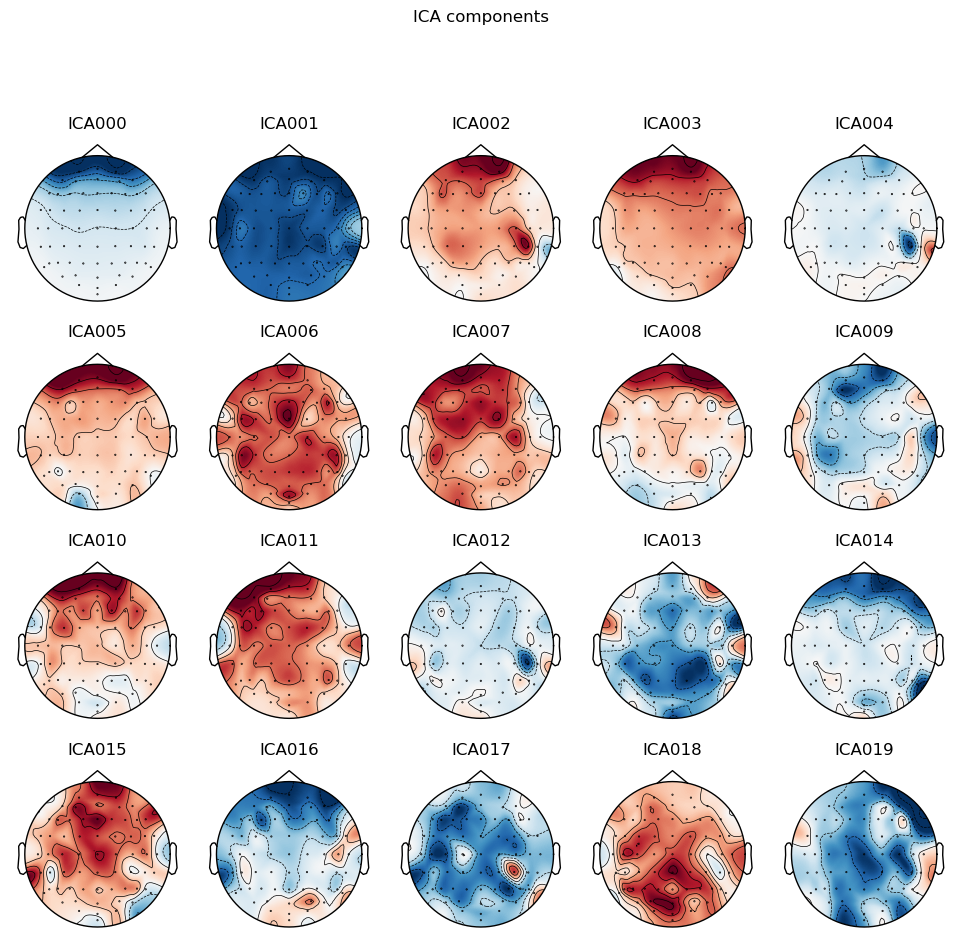

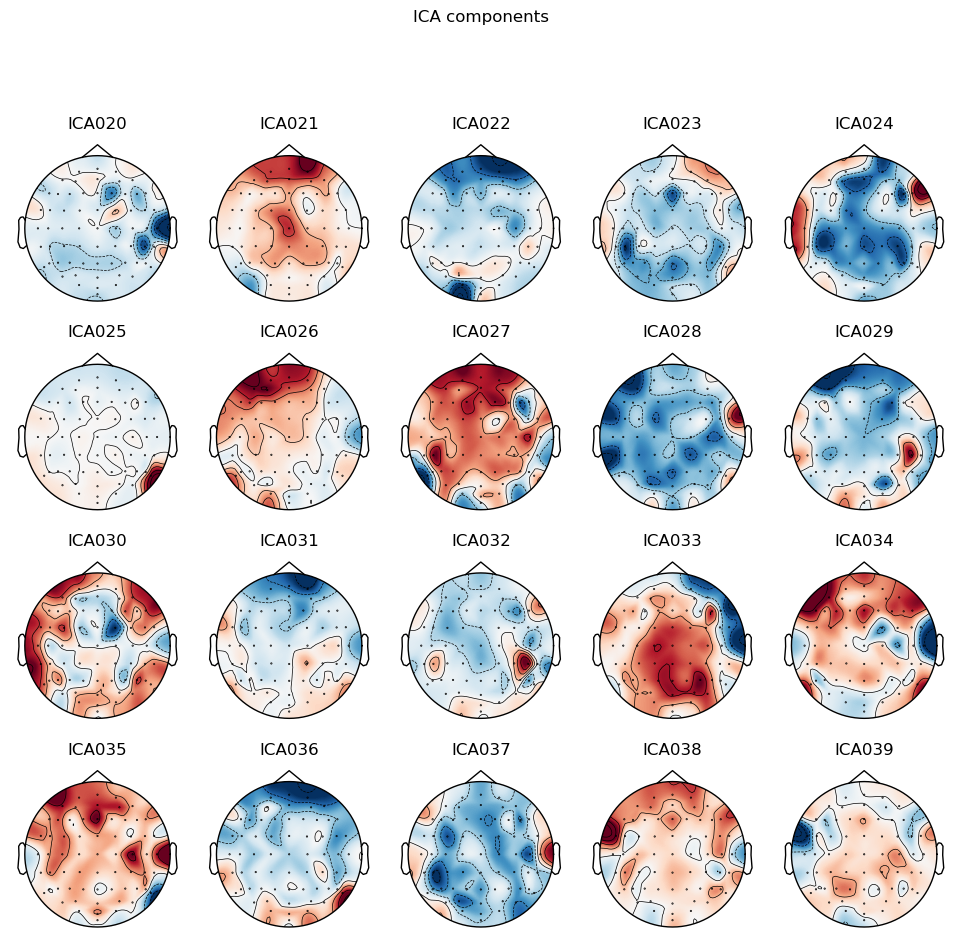

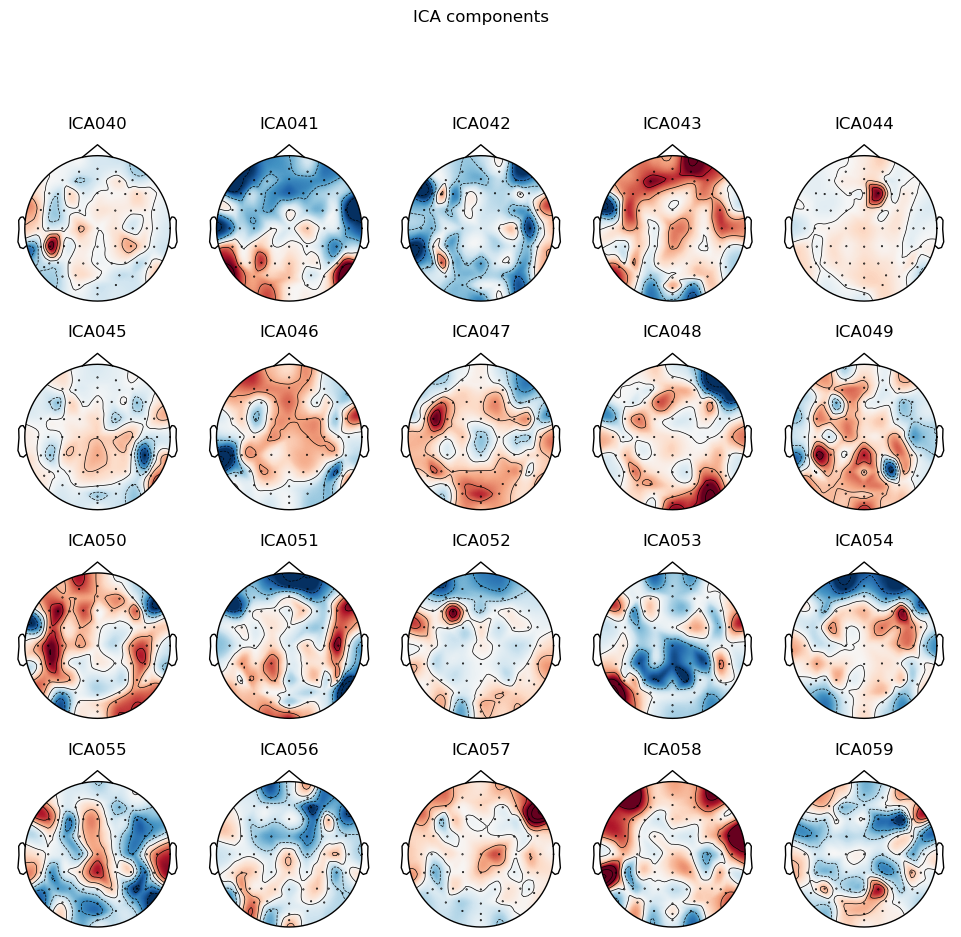

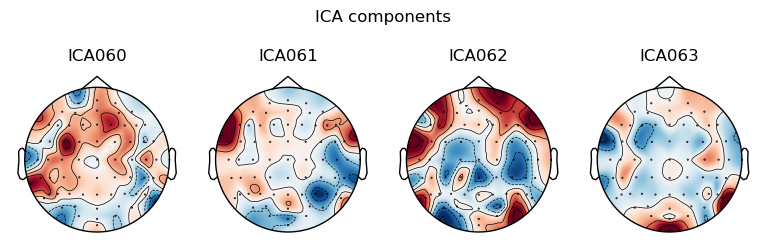

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [8]:
ica.plot_components()

In [9]:
ica.exclude = [0,3]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 74240 (580.0 s), ~36.3 MB, data loaded>

## PLOTS

All keystroke ERPs

In [10]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])

Not setting metadata
527 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 527 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


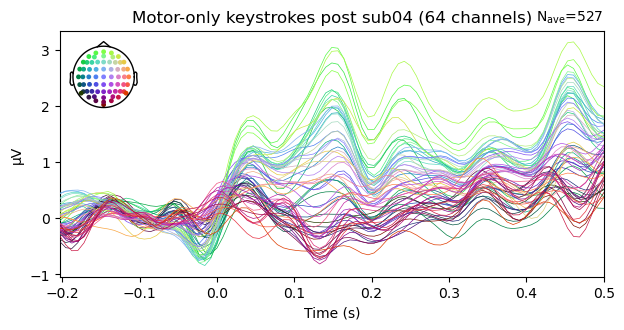

In [11]:
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.2, tmax=0.5, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
fig = evoked.plot(titles = f'Motor-only keystrokes {period} sub{subject_ID}')
fig.savefig(f'{figure_folder}/{subject_ID}_motor_{period}.png')

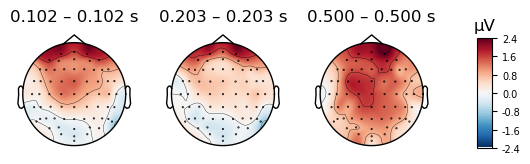

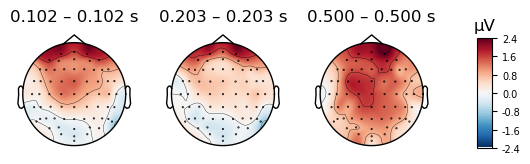

In [22]:
evoked.plot_topomap(times=[0.1, 0.2, 0.5], average=0.0001)

In [13]:
evoked.get_data()


array([[-1.16843205e-07, -1.22520601e-08,  9.78263222e-08, ...,
         1.96428711e-06,  1.83023099e-06,  1.81725947e-06],
       [-3.13742896e-07, -2.20051366e-07, -1.09800250e-07, ...,
         1.50344569e-06,  1.40165880e-06,  1.41060650e-06],
       [ 1.80671987e-07,  2.37106997e-07,  2.80299737e-07, ...,
         1.63136614e-06,  1.48345579e-06,  1.43028599e-06],
       ...,
       [-3.14012015e-07, -4.72985295e-07, -5.78470220e-07, ...,
         5.86691969e-08,  3.48869451e-07,  6.05978647e-07],
       [-2.12095837e-07, -3.36474803e-07, -4.17400042e-07, ...,
         5.11443539e-07,  7.72649436e-07,  1.01227202e-06],
       [-1.16291142e-07, -2.61263006e-07, -3.72385454e-07, ...,
         4.58085657e-07,  7.17009382e-07,  9.54950691e-07]])

In [15]:
mne.write_evokeds('erp.fif', evoked)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_82011/147495297.py:1: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/erp.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds('erp.fif', evoked)
